In [1]:
%run ../../Environment/environment_withoutPortfolio.ipynb

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'environment_withoutPortfolio.ipynb' matched no files


c:\Users\ntekaatl\OneDrive - Cisco\Documents\A Studientarbeit\Kaka\Studienarbeit\Agents\DQN
Notebook ausgeführt


In [2]:
import os
import sys

# Move up to the correct project root
project_root = os.path.abspath(os.path.join(os.getcwd(), "..",".."))
sys.path.append(project_root)

print("Updated Python path:", sys.path)  # Debugging check

Updated Python path: ['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env', '', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages\\win32', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\Documents\\A Studientarbeit\\Kaka\\Studienarbeit\\trading_env\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\ntekaatl\\OneDrive - Cisco\\D

In [ ]:
!jupyter nbconvert --to script DQN_Agent.ipynb

[NbConvertApp] Converting notebook DQN_Agent.ipynb to script
[NbConvertApp] Writing 13842 bytes to DQN_Agent.py


In [3]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from collections import Counter
from torch import nn

c:\Users\ntekaatl\OneDrive - Cisco\Documents\A Studientarbeit\Kaka\Studienarbeit\trading_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
seed = 42
SEED  = seed % (2**32 - 1)
print(f"SEED: {SEED}")

SEED: 42


In [5]:
# -------------------------------
# CSV Daten einlesen
# -------------------------------
train_data = pd.read_csv("../../Transform_data/stand_data/2023-2018_stand_data.csv")
train_data.drop('datetime', axis=1, inplace=True)

test_data = pd.read_csv("../../Transform_data/stand_data/2025-2024_stand_data.csv")
test_data.drop('datetime', axis=1, inplace=True)

if train_data is not None and test_data is not None:
    print("Daten erfolgreich eingelesen")

Daten erfolgreich eingelesen


In [6]:
# Für Hyperparameter-Tuning nutzen wir test_data als Validierungsdatensatz.
valid_data = test_data.copy()

# -------------------------------
# Evaluation Helper Function
# -------------------------------
def evaluate_agent(model, env, n_eval_episodes=5):
    """
    Evaluate the model over a number of episodes.
    Returns the average cumulative reward.
    """
    episode_rewards = []
    for _ in range(n_eval_episodes):
        # Handle reset return for compatibility with gym vs. gymnasium APIs
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            obs, info = reset_result
        else:
            obs = reset_result
        done = False
        total_reward = 0.0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            step_result = env.step(action)
            # Check length to handle different API outputs
            if len(step_result) == 5:
                obs, reward, done, truncated, info = step_result
            else:
                obs, reward, done, info = step_result
            total_reward += reward
        episode_rewards.append(total_reward)
    return np.mean(episode_rewards)

In [7]:
def objective(trial):
    from stable_baselines3 import DQN
    from stable_baselines3.common.vec_env import DummyVecEnv
    from Environment.environment_withPortfolio import TradingEnv_withPortfolio
    import numpy as np
    import gc

    TradingEnv = TradingEnv_withPortfolio
    try:
        BASE_DIR = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        BASE_DIR = os.getcwd()
    scaler_path = os.path.join(BASE_DIR, '..', '..', 'Transform_data', 'scaler.pkl')

    # === Hyperparameter-Sampling ===
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.9999)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    net_arch = trial.suggest_categorical("net_arch", [[64, 64], [128, 128], [256, 256]])
    tau = trial.suggest_float("tau", 0.01, 1.0)
    exploration_fraction = trial.suggest_float("exploration_fraction", 0.1, 0.5)
    target_update_interval = trial.suggest_int("target_update_interval", 100, 1000)

    policy_kwargs = dict(net_arch=net_arch)

    # === Training- und Validierungsumgebung erstellen ===
    env_train = DummyVecEnv([lambda: TradingEnv(
        data=train_data,
        initial_cash=1,
        window_size=336,
        scaler_path=scaler_path,
        default_seed=SEED
    )])

    env_valid = DummyVecEnv([lambda: TradingEnv(
        data=valid_data,
        initial_cash=1,
        window_size=336,
        scaler_path=scaler_path,
        default_seed=SEED
    )])

    # === Modell erstellen ===
    model = DQN(
        "MlpPolicy",
        env_train,
        learning_rate=learning_rate,
        gamma=gamma,
        batch_size=batch_size,
        tau=tau,
        exploration_fraction=exploration_fraction,
        target_update_interval=target_update_interval,
        buffer_size=10_000,  # Speicherfreundlich
        
        verbose=0,
        seed=SEED,
        policy_kwargs=policy_kwargs
    )

    # === Modell trainieren ===
    model.learn(total_timesteps=50_000)

    # === Evaluation auf Validierungsumgebung ===
    rewards = []
    sharpe_ratios = []

    for _ in range(3):
        obs = env_valid.reset()
        if isinstance(obs, tuple):
            obs, info = obs
        done = False
        total_reward = 0
        portfolio = []

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            result = env_valid.step(action)
            if len(result) == 5:
                obs, reward, done, truncated, info = result
            else:
                obs, reward, done, info = result

            total_reward += reward
            # Sicherstellen, dass portfolio_value im Info dict enthalten ist
            if isinstance(info, dict) and "portfolio_value" in info:
                portfolio.append(info["portfolio_value"])

        rewards.append(total_reward)

        # === Sharpe Ratio berechnen ===
        if len(portfolio) > 2:
            returns = np.diff(portfolio) / portfolio[:-1]
            if returns.std() != 0:
                sharpe = np.mean(returns) / np.std(returns) * np.sqrt(8760)
                sharpe_ratios.append(sharpe)

    # === Score berechnen ===
    avg_reward = np.mean(rewards)
    avg_sharpe = np.mean(sharpe_ratios) if sharpe_ratios else 0.0
    score = avg_reward + avg_sharpe  

    # === Pruning prüfen ===
    trial.report(score, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    # === Speicher bereinigen ===
    del model, env_train, env_valid
    gc.collect()

    return score


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Best hyperparameters:", study.best_trial.params)

[I 2025-04-13 18:56:56,680] A new study created in memory with name: no-name-9fd0ec68-775d-41bd-8516-14263428e567
c:\Users\ntekaatl\OneDrive - Cisco\Documents\A Studientarbeit\Kaka\Studienarbeit\trading_env\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\ntekaatl\OneDrive - Cisco\Documents\A Studientarbeit\Kaka\Studienarbeit\trading_env\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\ntekaatl\OneDrive - Cisco\Documents\A Studientarbeit\Kaka\Studienarbeit\trading_env\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple 

c:\Users\ntekaatl\OneDrive - Cisco\Documents\A Studientarbeit\Kaka\Studienarbeit\Agents\DQN
Notebook ausgeführt
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 18:57:48,794] Trial 0 finished with value: -112.3192367553711 and parameters: {'learning_rate': 6.893941375412613e-05, 'gamma': 0.977204294477297, 'batch_size': 128, 'net_arch': [64, 64], 'tau': 0.04954464219991924, 'exploration_fraction': 0.27949686854286077, 'target_update_interval': 427}. Best is trial 0 with value: -112.3192367553711.
c:\Users\ntekaatl\OneDrive - Cisco\Documents\A Studientarbeit\Kaka\Studienarbeit\trading_env\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\ntekaatl\OneDrive - Cisco\Documents\A Studientarbeit\Kaka\Studienarbeit\trading_env\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type 

Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 18:58:38,292] Trial 1 finished with value: -73.83853149414062 and parameters: {'learning_rate': 0.00016312264725094682, 'gamma': 0.9380910821687505, 'batch_size': 128, 'net_arch': [64, 64], 'tau': 0.5735068060924904, 'exploration_fraction': 0.32499937645450994, 'target_update_interval': 815}. Best is trial 1 with value: -73.83853149414062.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 18:59:30,232] Trial 2 finished with value: -92.84278106689453 and parameters: {'learning_rate': 0.0064794242002553975, 'gamma': 0.9627243918349092, 'batch_size': 64, 'net_arch': [64, 64], 'tau': 0.21925320151834352, 'exploration_fraction': 0.49920250230897256, 'target_update_interval': 169}. Best is trial 1 with value: -73.83853149414062.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:00:35,957] Trial 3 finished with value: -92.72350311279297 and parameters: {'learning_rate': 0.00010501459331710367, 'gamma': 0.9901179754378013, 'batch_size': 128, 'net_arch': [64, 64], 'tau': 0.15298213493631668, 'exploration_fraction': 0.4157923222590453, 'target_update_interval': 435}. Best is trial 1 with value: -73.83853149414062.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:02:05,541] Trial 4 finished with value: -106.9516830444336 and parameters: {'learning_rate': 3.591786557476484e-05, 'gamma': 0.9714354699032387, 'batch_size': 32, 'net_arch': [256, 256], 'tau': 0.9396148906478617, 'exploration_fraction': 0.42341092827269544, 'target_update_interval': 215}. Best is trial 1 with value: -73.83853149414062.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:03:27,487] Trial 5 finished with value: -87.2966079711914 and parameters: {'learning_rate': 9.239912421167119e-05, 'gamma': 0.9690553589714727, 'batch_size': 32, 'net_arch': [128, 128], 'tau': 0.5436129989037546, 'exploration_fraction': 0.1832897972853647, 'target_update_interval': 968}. Best is trial 1 with value: -73.83853149414062.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:05:02,171] Trial 6 finished with value: -16.858549118041992 and parameters: {'learning_rate': 0.002353127890017597, 'gamma': 0.9119235437725629, 'batch_size': 32, 'net_arch': [256, 256], 'tau': 0.25079910239986286, 'exploration_fraction': 0.2493882758591647, 'target_update_interval': 139}. Best is trial 6 with value: -16.858549118041992.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:06:32,743] Trial 7 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:07:56,366] Trial 8 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:08:44,917] Trial 9 finished with value: -85.02080535888672 and parameters: {'learning_rate': 0.00015334675439507736, 'gamma': 0.9582593351122135, 'batch_size': 32, 'net_arch': [64, 64], 'tau': 0.4831876286991894, 'exploration_fraction': 0.2526315819152055, 'target_update_interval': 888}. Best is trial 6 with value: -16.858549118041992.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:09:45,118] Trial 10 finished with value: -44.4947509765625 and parameters: {'learning_rate': 0.001147483467266595, 'gamma': 0.9043035042326905, 'batch_size': 32, 'net_arch': [128, 128], 'tau': 0.3150558491235474, 'exploration_fraction': 0.10671235621279501, 'target_update_interval': 585}. Best is trial 6 with value: -16.858549118041992.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:10:43,496] Trial 11 finished with value: -82.43904876708984 and parameters: {'learning_rate': 0.000976735207859851, 'gamma': 0.9000694791731382, 'batch_size': 32, 'net_arch': [128, 128], 'tau': 0.38327680471843484, 'exploration_fraction': 0.10692424133644104, 'target_update_interval': 606}. Best is trial 6 with value: -16.858549118041992.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:11:53,215] Trial 12 finished with value: -55.19496536254883 and parameters: {'learning_rate': 0.0010712677011785634, 'gamma': 0.9011484351663928, 'batch_size': 32, 'net_arch': [128, 128], 'tau': 0.33613223740755266, 'exploration_fraction': 0.11001947023043146, 'target_update_interval': 432}. Best is trial 6 with value: -16.858549118041992.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:13:31,885] Trial 13 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:14:38,304] Trial 14 finished with value: -54.16958236694336 and parameters: {'learning_rate': 0.0023322207861331875, 'gamma': 0.9211644716639275, 'batch_size': 32, 'net_arch': [128, 128], 'tau': 0.6454860432718369, 'exploration_fraction': 0.34971403901259634, 'target_update_interval': 329}. Best is trial 6 with value: -16.858549118041992.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:15:43,166] Trial 15 finished with value: -36.68841552734375 and parameters: {'learning_rate': 0.0004197913564228469, 'gamma': 0.9167062804807342, 'batch_size': 32, 'net_arch': [128, 128], 'tau': 0.6931913641086997, 'exploration_fraction': 0.15629191703383127, 'target_update_interval': 104}. Best is trial 6 with value: -16.858549118041992.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:17:04,464] Trial 16 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:18:25,691] Trial 17 finished with value: -65.07390594482422 and parameters: {'learning_rate': 0.0004597040314903735, 'gamma': 0.9387185647836488, 'batch_size': 32, 'net_arch': [256, 256], 'tau': 0.7161389577040294, 'exploration_fraction': 0.15798874766935755, 'target_update_interval': 107}. Best is trial 6 with value: -16.858549118041992.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:19:32,743] Trial 18 finished with value: -16.697675704956055 and parameters: {'learning_rate': 0.00312849894330585, 'gamma': 0.9147450197512358, 'batch_size': 64, 'net_arch': [128, 128], 'tau': 0.44771169660943555, 'exploration_fraction': 0.35402294093272757, 'target_update_interval': 124}. Best is trial 18 with value: -16.697675704956055.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:20:24,398] Trial 19 finished with value: -21.05837059020996 and parameters: {'learning_rate': 0.0026012776342585757, 'gamma': 0.9316257252637865, 'batch_size': 64, 'net_arch': [128, 128], 'tau': 0.46068041534633036, 'exploration_fraction': 0.3567260161992179, 'target_update_interval': 312}. Best is trial 18 with value: -16.697675704956055.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:21:30,694] Trial 20 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:22:20,951] Trial 21 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:23:12,121] Trial 22 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:24:09,663] Trial 23 finished with value: -0.8835436701774597 and parameters: {'learning_rate': 0.00943940456669741, 'gamma': 0.912032534598363, 'batch_size': 64, 'net_arch': [128, 128], 'tau': 0.25238081829288816, 'exploration_fraction': 0.3798637780042044, 'target_update_interval': 100}. Best is trial 23 with value: -0.8835436701774597.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:25:06,053] Trial 24 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:26:06,596] Trial 25 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:27:38,373] Trial 26 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:28:50,451] Trial 27 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:29:52,613] Trial 28 finished with value: -10.399621963500977 and parameters: {'learning_rate': 0.0040461861038438305, 'gamma': 0.9082088035633075, 'batch_size': 64, 'net_arch': [128, 128], 'tau': 0.24970937612157873, 'exploration_fraction': 0.26226862683711805, 'target_update_interval': 385}. Best is trial 23 with value: -0.8835436701774597.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:30:53,797] Trial 29 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:31:54,126] Trial 30 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:32:53,898] Trial 31 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:33:50,353] Trial 32 finished with value: -7.116770267486572 and parameters: {'learning_rate': 0.005654162276274536, 'gamma': 0.9084143752936609, 'batch_size': 128, 'net_arch': [64, 64], 'tau': 0.2828080561606078, 'exploration_fraction': 0.32197245691299065, 'target_update_interval': 507}. Best is trial 23 with value: -0.8835436701774597.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:34:45,514] Trial 33 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:35:39,792] Trial 34 finished with value: 7.1519341468811035 and parameters: {'learning_rate': 0.0096737240428082, 'gamma': 0.9048348939751444, 'batch_size': 128, 'net_arch': [64, 64], 'tau': 0.18273825650810283, 'exploration_fraction': 0.33788546541150777, 'target_update_interval': 467}. Best is trial 34 with value: 7.1519341468811035.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:36:37,101] Trial 35 finished with value: -4.65939998626709 and parameters: {'learning_rate': 0.00825393457227248, 'gamma': 0.90655731725136, 'batch_size': 128, 'net_arch': [64, 64], 'tau': 0.17560423789953933, 'exploration_fraction': 0.305706529513534, 'target_update_interval': 491}. Best is trial 34 with value: 7.1519341468811035.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:37:31,008] Trial 36 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:38:25,482] Trial 37 finished with value: -14.640429496765137 and parameters: {'learning_rate': 0.009831387353536138, 'gamma': 0.9044749039242003, 'batch_size': 128, 'net_arch': [64, 64], 'tau': 0.08226708533281944, 'exploration_fraction': 0.4456954219784335, 'target_update_interval': 469}. Best is trial 34 with value: 7.1519341468811035.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:39:19,412] Trial 38 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:40:13,838] Trial 39 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:41:11,999] Trial 40 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:42:13,923] Trial 41 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:43:14,661] Trial 42 finished with value: -25.9875431060791 and parameters: {'learning_rate': 0.00427938808929579, 'gamma': 0.9077360971972877, 'batch_size': 128, 'net_arch': [64, 64], 'tau': 0.20473374711403994, 'exploration_fraction': 0.22866045574291308, 'target_update_interval': 470}. Best is trial 34 with value: 7.1519341468811035.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:44:12,098] Trial 43 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:45:06,938] Trial 44 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:46:00,646] Trial 45 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:46:54,097] Trial 46 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:47:47,810] Trial 47 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:48:40,365] Trial 48 pruned. 


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-04-13 19:49:34,189] Trial 49 pruned. 


Seed in the environment: 42
Best hyperparameters: {'learning_rate': 0.0096737240428082, 'gamma': 0.9048348939751444, 'batch_size': 128, 'net_arch': [64, 64], 'tau': 0.18273825650810283, 'exploration_fraction': 0.33788546541150777, 'target_update_interval': 467}


In [8]:
# -------------------------------
# TradingEnv erstellen (Final Environment using train_data)
# -------------------------------
env = TradingEnv_withoutPortfolio(
    data=train_data,
    initial_cash=1,
    window_size=168,
    scaler_path="../../Transform_data/scaler.pkl",
    default_seed=SEED
)

if env is not None:
    print("Environment created successfully")

Seed in the environment: 42
Environment created successfully


In [9]:
# -------------------------------
# DQN-Agenten initialisieren using Best Hyperparameters
# -------------------------------
model = DQN(
    policy="MlpPolicy",
    env=env,
    buffer_size=50000,
    seed=SEED,
    policy_kwargs=dict(activation_fn=nn.ReLU)
)

In [10]:
# -------------------------------
# Training
# -------------------------------
model.learn(
    total_timesteps=10000, 
    log_interval=1
)

# Speichere das trainierte Modell
model.save("DQN_final_verglich")

Seed in the environment: 42


Seed in the environment: 42


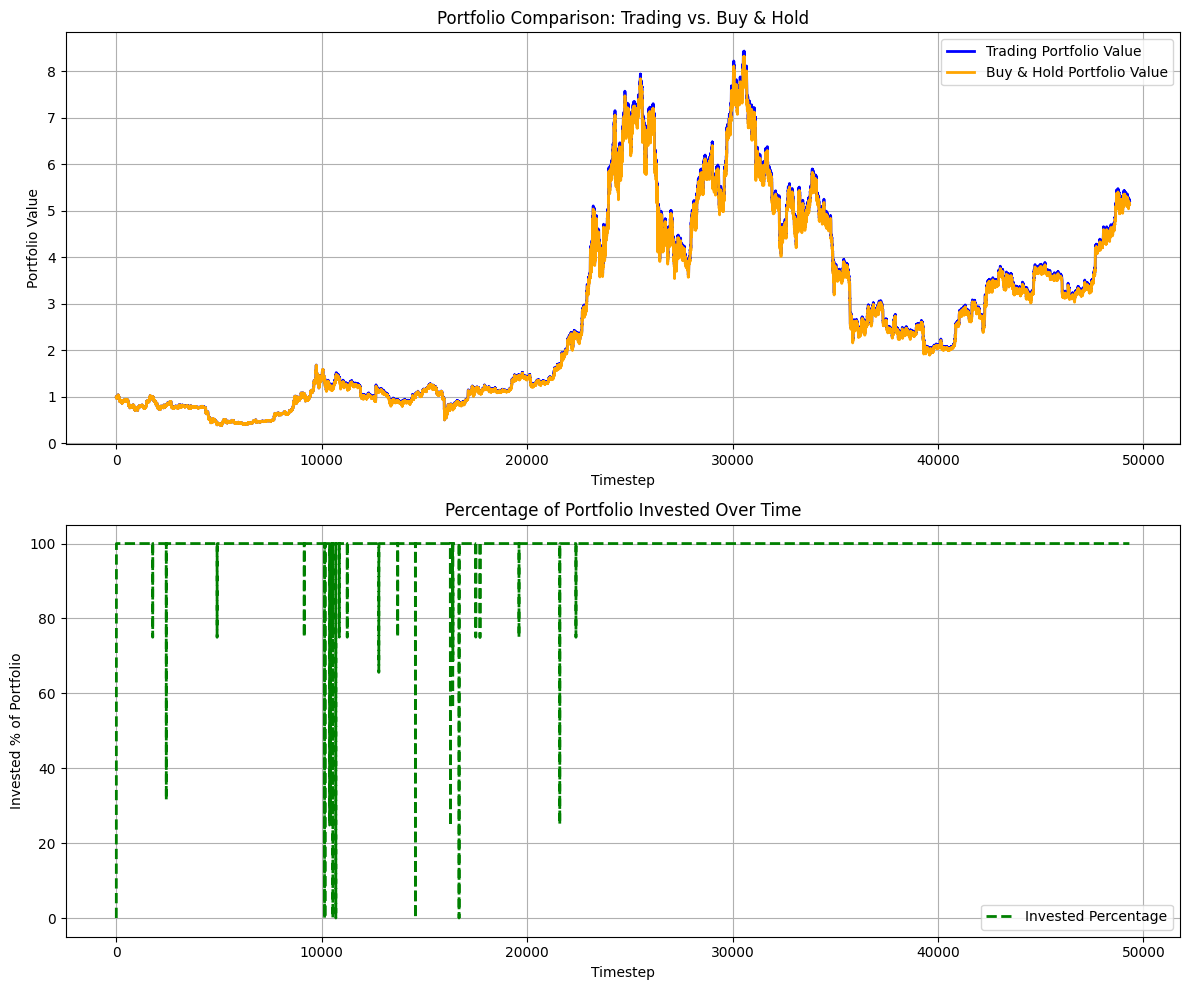

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [12]:
# -------------------------------
# Testlauf: Den trainierten Agenten in einer Episode ausführen (Training Environment)
# -------------------------------
training_env = env

reset_result = training_env.reset(seed=SEED)
if isinstance(reset_result, tuple):
    obs, info = reset_result
else:
    obs = reset_result
done = False

# Liste der Aktionen
action_list = []

while not done:
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # oder: action = action.item()
    step_result = training_env.step(action)
    if len(step_result) == 5:
        obs, reward, done, truncated, info = step_result
    else:
        obs, reward, done, info = step_result
    action_list.append(action)

# Rendern des aktuellen Zustands (z.B. als Plot)
training_env.render(mode='human')
print(action_list)

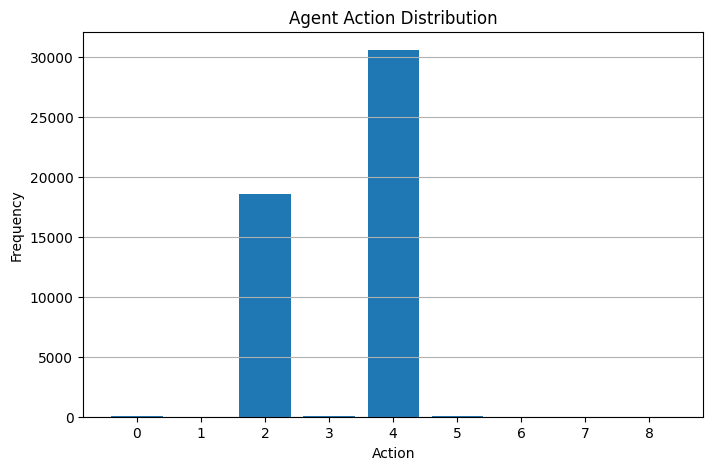

In [13]:

# -------------------------------
# Plot Action Distribution
# -------------------------------
action_counts = Counter(action_list)
actions = list(range(9))
counts = [action_counts.get(action, 0) for action in actions]

plt.figure(figsize=(8, 5))
plt.bar(actions, counts, tick_label=actions)
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Agent Action Distribution")
plt.grid(axis='y')
plt.show()

Seed in the environment: 42
Seed in the environment: 42


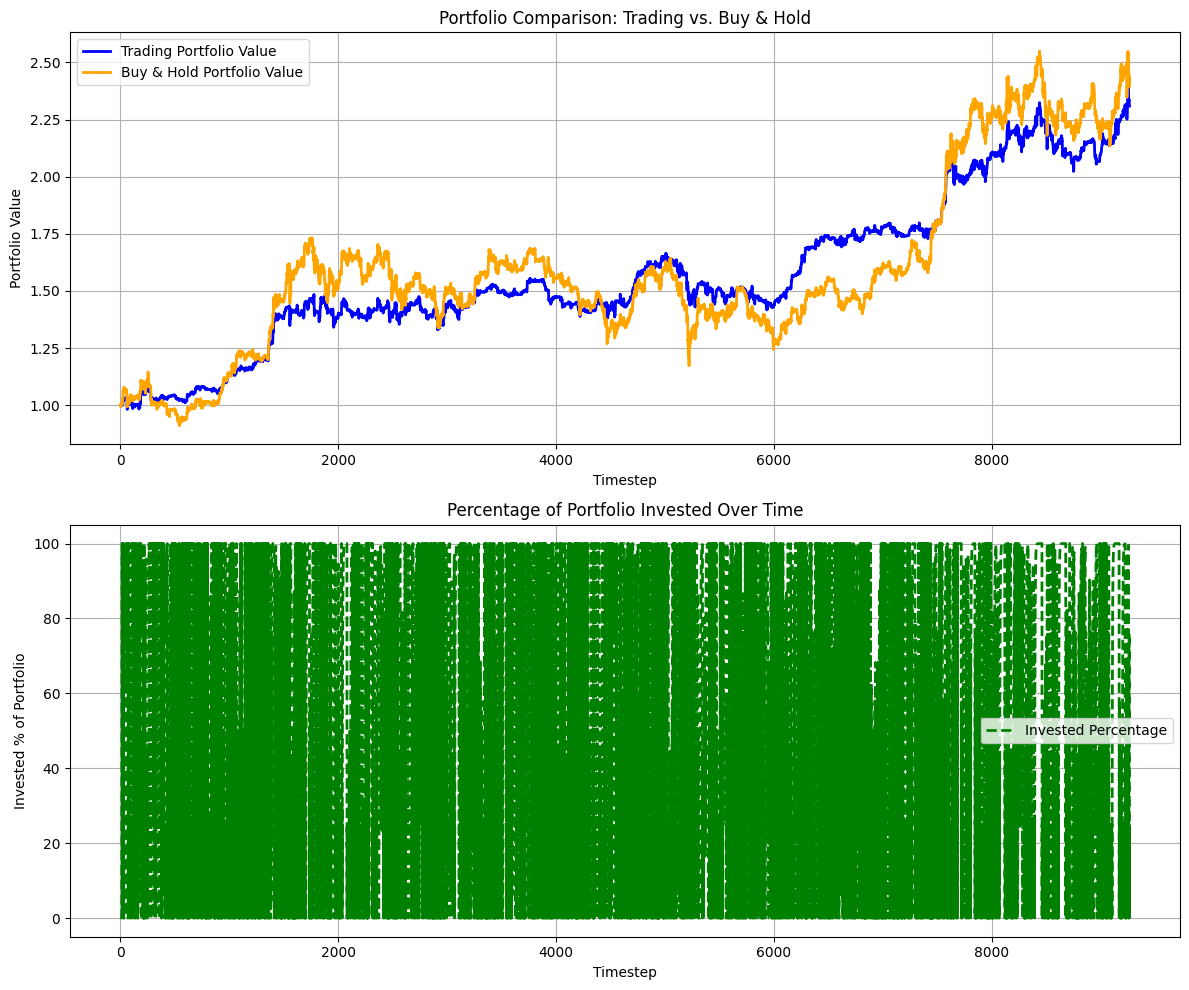

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 4, 8, 8, 4, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 2, 2, 1, 1, 2, 4, 2, 2, 4, 4, 1, 4, 5, 1, 5, 1, 4, 4, 1, 1, 1, 8, 0, 8, 5, 8, 4, 4, 8, 0, 5, 7, 7, 5, 8, 4, 0, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 8, 7, 8, 8, 1, 8, 5, 0, 8, 4, 8, 4, 4, 4, 0, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 8, 8, 1, 1, 1, 8, 7, 4, 4, 3, 2, 2, 8, 8, 8, 2, 8, 8, 2, 8, 7, 7, 7, 7, 1, 7, 1, 1, 0, 4, 7, 4, 4, 0, 0, 0, 7, 1, 1, 1, 7, 7, 4, 4, 4, 1, 5, 0, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 2, 1, 2, 2, 1, 8, 4, 8, 4, 8, 1, 8, 1, 1, 8, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 7, 1, 1, 8, 8, 1, 1, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 4, 0, 7, 1, 1, 4, 4, 4, 4, 4, 8, 0, 4, 1, 4, 4, 4, 1, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 2, 1, 4, 4, 7, 4, 4, 4, 7, 4, 7, 7, 7, 7, 4, 7, 4, 8, 4, 4, 7, 7, 7, 4, 4, 4, 4, 7, 7, 7, 7, 7, 4, 0, 4, 4, 4, 4, 4, 

In [11]:
# -------------------------------
# Testlauf: Den trainierten Agenten in einer Episode ausführen
# -------------------------------
test_env = TradingEnv_withoutPortfolio(
    data=test_data,
    initial_cash=1,
    window_size=168,
    scaler_path="../../Transform_data/scaler.pkl",
    default_seed=SEED
)

obs, info = test_env.reset(seed=SEED)
done = False

# Liste der actionen
action_list = []

while not done:
    # Bestimme die Aktion (deterministisch)
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # oder: action = action.item()
    obs, reward, done, truncated, info = test_env.step(action)
    action_list.append(action)

# Hier wird der Zustand gerendert (z.B. als Plot). Du kannst den Render-Modus anpassen.
test_env.render(mode='human')
print(action_list)

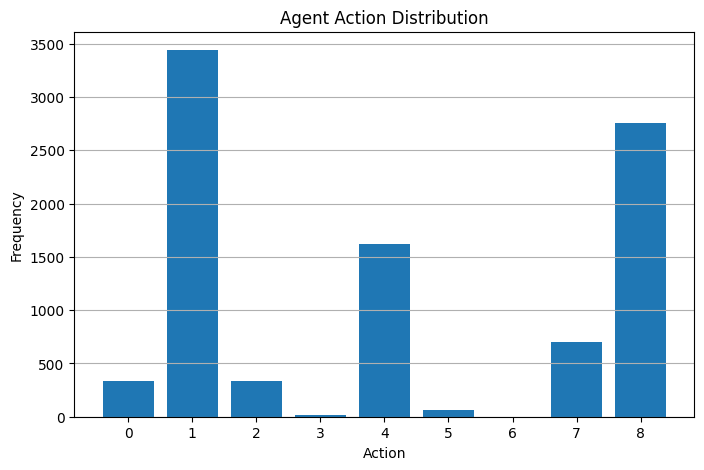

In [12]:

# -------------------------------
# Plot Action Distribution
# -------------------------------
action_counts = Counter(action_list)
actions = list(range(9))
counts = [action_counts.get(action, 0) for action in actions]

plt.figure(figsize=(8, 5))
plt.bar(actions, counts, tick_label=actions)
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Agent Action Distribution")
plt.grid(axis='y')
plt.show()

In [ ]:
import numpy as np

def compute_sharpe_ratio(portfolio_values, risk_free_rate=0.0, periods_per_year=8760):
    """
    Compute the Sharpe Ratio using the portfolio returns.
    
    Parameters:
    - portfolio_values: List or array of portfolio values over time.
    - risk_free_rate: Annual risk-free rate (default: 0).
    - periods_per_year: Number of periods in one year (default: 8760 for hourly data).
    
    Returns:
    - Sharpe ratio (annualized).
    """
    portfolio_values = np.array(portfolio_values)
    # Calculate period-to-period returns
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    # Calculate excess returns over the period risk-free rate
    excess_returns = returns - risk_free_rate / periods_per_year
    # Annualize the Sharpe Ratio
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(periods_per_year)
    return sharpe_ratio

def compute_max_drawdown(portfolio_values):
    """
    Compute the Maximum Drawdown from the portfolio value history.
    
    Parameters:
    - portfolio_values: List or array of portfolio values over time.
    
    Returns:
    - Maximum drawdown as a negative number (e.g., -0.2 means a 20% drawdown).
    """
    portfolio_values = np.array(portfolio_values)
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - cumulative_max) / cumulative_max
    max_drawdown = np.min(drawdowns)
    return max_drawdown

def compute_annualized_return(portfolio_values, periods_per_year=8760):
    """
    Compute the annualized return (CAGR) based on the portfolio value history.
    
    Parameters:
    - portfolio_values: List or array of portfolio values over time.
    - periods_per_year: Number of periods in one year.
    
    Returns:
    - Annualized return as a decimal (e.g., 0.12 for 12% per year).
    """
    portfolio_values = np.array(portfolio_values)
    total_periods = len(portfolio_values)
    total_return = portfolio_values[-1] / portfolio_values[0]
    annualized_return = total_return**(periods_per_year / total_periods) - 1
    return annualized_return

def compute_win_loss_rate(portfolio_values):
    """
    Compute the win-loss rate based on the period-to-period returns.
    
    Parameters:
    - portfolio_values: List or array of portfolio values over time.
    
    Returns:
    - A tuple (win_rate, loss_rate) where each value is between 0 and 1.
    """
    portfolio_values = np.array(portfolio_values)
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    wins = np.sum(returns > 0)
    losses = np.sum(returns <= 0)
    win_rate = wins / (wins + losses) if (wins + losses) > 0 else 0
    loss_rate = 1 - win_rate
    return win_rate, loss_rate

def compute_backtest_metrics(portfolio_values, risk_free_rate=0.0, periods_per_year=8760):
    """
    Compute a set of backtesting metrics: Sharpe Ratio, Maximum Drawdown,
    Annualized Return, and Win-Loss Rate.
    
    Parameters:
    - portfolio_values: List or array of portfolio values over time.
    - risk_free_rate: Annual risk-free rate (default: 0).
    - periods_per_year: Number of periods in one year.
    
    Returns:
    - Dictionary with computed metrics.
    """
    sharpe = compute_sharpe_ratio(portfolio_values, risk_free_rate, periods_per_year)
    max_drawdown = compute_max_drawdown(portfolio_values)
    annualized_return = compute_annualized_return(portfolio_values, periods_per_year)
    win_rate, loss_rate = compute_win_loss_rate(portfolio_values)
    
    return {
        "Sharpe Ratio": sharpe,
        "Maximum Drawdown": max_drawdown,
        "Annualized Return": annualized_return,
        "Win Rate": win_rate,
        "Loss Rate": loss_rate
    }

# Example usage with your environment's portfolio history:
# Assuming you have a TradingEnv instance named 'test_env' that has completed an episode:
metrics = compute_backtest_metrics(test_env.portfolio_value_history, risk_free_rate=0.0, periods_per_year=8760)
print("Backtesting Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


Backtesting Metrics:
Sharpe Ratio: 0.6545
Maximum Drawdown: -0.4423
Annualized Return: 0.1956
Win Rate: 0.3195
Loss Rate: 0.6805


: 